# Importar

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.integrate import odeint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Funciones de ayuda

In [ ]:
# Lotka Volterra mutualismo
def sim(variables, t, params):

      # fish population level
      x = variables[0]
      # bear population level
      y = variables[1]
      r1 = params[0]
      r2 = params[1]
      alpha = params[2]
      beta = params[3]
      delta = params[4]
      gamma = params[5]

      dxdt = r1*x*(1 - alpha*x + beta* y)
      dydt = r2*y*(1 + delta*x - gamma*y)

      return([dxdt, dydt])

# Lotka Volterra competencia
def sim1(variables, t, paramsc):

    # fish population level
    x = variables[0]

    # bear population level
    y = variables[1]


    alpha = paramsc[0]
    beta = paramsc[1]
    delta = paramsc[2]
    gamma = paramsc[3]

    dxdtc = alpha * x - beta * x * y
    dydtc = delta * x * y - gamma * y

    return([dxdtc, dydtc])


#Función trueque mutualista

In [ ]:
def tru_mut(Pi, Pi1):
    P = Pi.copy()
    P1 = Pi1.copy()
    inicial = np.concatenate((Pi, Pi1))
    #varianza0 muestra la varianza de la distribución inicial de capacidad de trueque
    #varianza0 = np.var(inicial)
    M = []
    t = np.arange(0, 201, 1)
    n = len(P)
    # Esto lo usé para ayudarme a establecer la mínima varianza
    varP = np.zeros(len(t))
    varP1 = np.zeros(len(t))
    # Todo este código hace las transacciones a lo largo del tiempo de manera que cada vez que una persona gana 1 bien o servicio
    # otra pierde un bien o servicio
    for step in range(len(t)):
        # Toma cada uno de los 4 grupos de tres personas y en cada grupo escoge una al azar que va a dar un bien o servicio (-1 bien o servicio)
        # y las otras compiten con un algoritmo basado en lotka-volterra mutualismo
        varP[step] = np.var(P)
        varP1[step] = np.var(P1)

        for _ in range(4):

            iq = random.randint(0, n-1)
            iq1 = random.randint(0, n-1)
            ilv1 = random.randint(0, n-1)
            ilv11 = random.randint(0, n-1)
            ilv2 = random.randint(0, n-1)
            ilv12 = random.randint(0, n-1)

            P[iq] -= 1
            P1[iq1] -= 1
            # Inicializar y0 con la capacidad de trueque de las personas elegidas a interactuar en mutualismo
            y0 = [Pi[ilv1], Pi[ilv2]]
            y10 = [Pi1[ilv11], Pi1[ilv12]]

            # Se avanza en el tiempo paso a paso para ser evaluado a cada instante en odeint
            tn = np.arange(0, (step+1), 1)

            params = [0.01, 0.01, 0.2, 0.1, 0.1, 0.2]

            # result contiene la derivada de la capacidad de trueque
            result = odeint(sim, y0, tn, args=(params,))
            result1 = odeint(sim, y10, tn, args=(params,))
            R = result[-1, :]
            R1 = result1[-1, :]
            dxdt, dydt = sim(R, tn, params)
            dxdt1, dydt1 = sim(R1, tn, params)
            # Al comparar las derivadas se decide darle un bien o servicio al que tenga el valor mayor de derivada
            if dxdt > dydt:
                P[ilv1] += 1
            else:
                P[ilv2] += 1

            if dxdt1 > dydt1:
                P1[ilv11] += 1
            else:
                P1[ilv12] += 1
            nfil = np.concatenate((P, P1))
            M.append(nfil)

    # Aquí se identifica una fila de la matriz M de acuerdo a la menor varianza encontrada ya sea en P o en P1
    indopt = np.argmin(varP)
    indopt1 = np.argmin(varP1)
    if indopt <= indopt1:
        m = indopt
        Fini = M[4*(m+1)]
    else:
        m = indopt1
        Fini = M[4*(m+1)]
    # A partir de esa fila tenemos PP y PP1
    # Primero saco una copia de la última fila de este proceso para abajo hacer un gráfico de barras
    fini = Fini.copy()
    PP = Fini[:12]
    PP1 = Fini[12:]
    # Esta es la primera parte de la matriz total que va a alimentar la red neuronal
    L =np.array(M[:4*(m+1)])
    #varianza1 muestra la varianza para la distribución de capacidad de trueque luego del trueque mutualista
    #varianza1 = np.var(fini)
    dim=L.shape[0]
    #El return comentado nos permite constatar la como disminuye la varianza después del trueque mutualista
    #return(varianza0, varianza1, dim, L)
    return (dim , L)


#Generación de la matriz de datos


In [ ]:
matrices = []
lim = []
for i in range(50):
  T=np.random.randint(1, 51, size=12)
  T1=np.random.randint(1, 51, size=12)
  nueva_matriz = tru_mut(T,T1)[1]
  matrices.append(nueva_matriz)
  lim.append(tru_mut(T,T1)[0])

matriz_final = np.vstack(matrices)

#print("Forma de la matriz final:", matriz_final.shape)
print(lim)

[216, 220, 216, 256, 192, 220, 268, 292, 192, 156, 296, 160, 300, 256, 328, 188, 296, 216, 240, 204, 220, 196, 128, 204, 160, 296, 336, 208, 108, 332, 188, 232, 140, 184, 320, 160, 268, 144, 228, 200, 284, 264, 160, 224, 220, 184, 176, 276, 124, 324]


# El dataframe para la red neuronal

In [ ]:
from sklearn.preprocessing import StandardScaler
#Voy a convertirlo en un dataframe de pandas
columnas0 = ['Persona01', 'Persona02', 'Persona03','Persona04', 'Persona05', 'Persona06',
            'Persona07', 'Persona08', 'Persona09','Persona010', 'Persona011', 'Persona012',
            'Persona013', 'Persona014', 'Persona015','Persona016', 'Persona017', 'Persona018',
            'Persona019', 'Persona020', 'Persona021','Persona022', 'Persona023', 'Persona024']

df0= pd.DataFrame(matriz_final, columns=columnas0)

scaler = StandardScaler()

# Normaliza todas las columnas numéricas
df0[df0.columns] = scaler.fit_transform(df0[df0.columns])
# Imprimir el DataFrame
print(df0)


       Persona01  Persona02  Persona03  Persona04  Persona05  Persona06  \
0      -2.365547   1.362291  -1.197417  -1.210665  -1.382640   0.396684   
1      -2.365547   1.362291  -1.197417  -1.312638  -1.299544   0.396684   
2      -2.365547   1.362291  -1.197417  -1.312638  -1.382640   0.396684   
3      -2.365547   1.362291  -1.197417  -1.312638  -1.382640   0.396684   
4      -2.365547   1.362291  -1.197417  -1.312638  -1.465736   0.396684   
...          ...        ...        ...        ...        ...        ...   
11247   0.200006  -0.343541  -0.241023  -0.394885  -0.219297  -0.076634   
11248   0.200006  -0.450155  -0.241023  -0.394885  -0.219297  -0.076634   
11249   0.200006  -0.450155  -0.327968  -0.394885  -0.219297  -0.076634   
11250   0.200006  -0.450155  -0.327968  -0.394885  -0.219297  -0.076634   
11251   0.200006  -0.450155  -0.327968  -0.394885  -0.219297  -0.171298   

       Persona07  Persona08  Persona09  Persona010  ...  Persona015  \
0      -1.147742  -0.341580 

<Axes: >

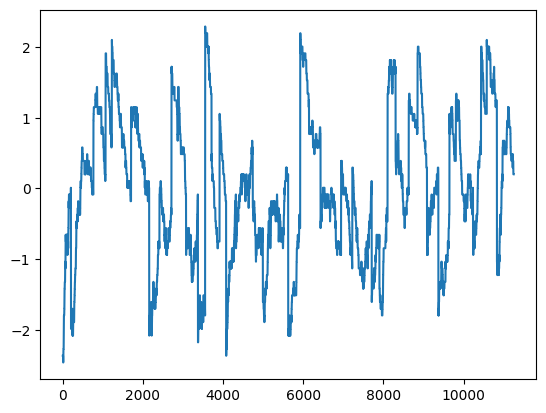

In [ ]:
Persona1 = df0['Persona01']
Persona1.plot()

# Preparación de datos para las Redes Neuronales

In [ ]:
df0.shape

(11252, 24)

In [ ]:
def df_to_X_y0(df, window_size=4):
  df_as_np = df.to_numpy()
  X0 = []
  y0 = []
  for step in range(50):
    for i in range(lim[step]-window_size):
      row = [r for r in df_as_np[i:i+window_size]]
      X0.append(row)
      label = df_as_np[i+window_size]
      y0.append(label)
  return np.array(X0), np.array(y0)

In [ ]:
X0, y0 = df_to_X_y0(df0)
X0.shape, y0.shape

((11000, 4, 24), (11000, 24))

In [ ]:
X0_train, y0_train = X0[:7500], y0[:7500]
X0_val, y0_val = X0[7500:8500], y0[7500:8500]
X0_test, y0_test = X0[8500:], y0[8500:]
X0_train.shape, y0_train.shape, X0_val.shape, y0_val.shape, X0_test.shape, y0_test.shape

((7500, 4, 24),
 (7500, 24),
 (1000, 4, 24),
 (1000, 24),
 (2500, 4, 24),
 (2500, 24))

In [ ]:
X0_train[0]

array([[-2.36554658,  1.36229129, -1.19741686, -1.21066545, -1.38264042,
         0.39668371, -1.14774228, -0.34158014, -0.30401816,  2.03458013,
         0.35008281, -0.01768537, -1.29514829,  1.08044806, -0.94602788,
         1.20471393,  1.56125437, -0.10735223, -1.72506907,  0.81772733,
        -0.90359726, -0.38185026, -1.02135194,  1.46137981],
       [-2.36554658,  1.36229129, -1.19741686, -1.31263797, -1.29954449,
         0.39668371, -1.14774228, -0.34158014, -0.30401816,  2.03458013,
         0.35008281, -0.01768537, -1.29514829,  1.08044806, -0.94602788,
         1.20471393,  1.56125437, -0.10735223, -1.72506907,  0.81772733,
        -0.90359726, -0.27023921, -1.11285003,  1.46137981],
       [-2.36554658,  1.36229129, -1.19741686, -1.31263797, -1.38264042,
         0.39668371, -1.14774228, -0.34158014, -0.30401816,  2.03458013,
         0.43636699, -0.01768537, -1.29514829,  1.08044806, -0.85074169,
         1.20471393,  1.56125437, -0.10735223, -1.72506907,  0.81772733,
  

# Tercer modelo basado en predicción climatológica aplicado a df0


In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import regularizers
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

model3 = Sequential()
model3.add(InputLayer((4, 24)))
model3.add(Conv1D(64, kernel_size=2, activation='relu'))
model3.add(LSTM(32, return_sequences=True))
model3.add(LSTM(16))
model3.add(Dense(8, 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(24, 'linear'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             3136      
                                                                 
 lstm (LSTM)                 (None, 3, 32)             12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 24)                216       
                                                                 
Total params: 19040 (74.38 KB)
Trainable params: 19040 (

In [ ]:
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


In [ ]:
model3.fit(X0_train, y0_train, validation_data=(X0_val, y0_val), batch_size=64, epochs=300, callbacks=[early_stopping_callback])

Epoch 1/300
118/118 [==============================] - 6s 14ms/step - loss: 0.8309 - root_mean_squared_error: 0.9115 - val_loss: 0.8210 - val_root_mean_squared_error: 0.9061
Epoch 2/300
118/118 [==============================] - 1s 6ms/step - loss: 0.7284 - root_mean_squared_error: 0.8535 - val_loss: 0.6745 - val_root_mean_squared_error: 0.8213
Epoch 3/300
118/118 [==============================] - 1s 7ms/step - loss: 0.6462 - root_mean_squared_error: 0.8039 - val_loss: 0.5819 - val_root_mean_squared_error: 0.7628
Epoch 4/300
118/118 [==============================] - 1s 6ms/step - loss: 0.5909 - root_mean_squared_error: 0.7687 - val_loss: 0.5119 - val_root_mean_squared_error: 0.7155
Epoch 5/300
118/118 [==============================] - 1s 6ms/step - loss: 0.5365 - root_mean_squared_error: 0.7324 - val_loss: 0.4490 - val_root_mean_squared_error: 0.6700
Epoch 6/300
118/118 [==============================] - 1s 6ms/step - loss: 0.4940 - root_mean_squared_error: 0.7028 - val_loss: 0.3939

# Función Plot

In [ ]:
from sklearn.metrics import mean_squared_error as mse

#def plot_predictions1(model, X, y, start=0, end=6000):
#  predictions = model.predict(X).flatten()
#  y=y.flatten()
#  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  #plt.plot(df['Persona1 p'][start:end])
  #plt.plot(df['Persona1 a'][start:end])
  #plt.plot(df['Pressure Predi'][start:end])
 # plt.plot(df['Pressure Actuals'][start:end])
#  return df, mse(predictions, y)


def plot_predictions(model, X, y, start=0, end=2000):
  predictions = model.predict(X)
  per1_p, per2_p = predictions[:, 0], predictions[:, 1]
  per1_a, per2_a = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Persona1 predicción': per1_p,
                          'Persona1 actual': per1_a,
                          'Persona2 predicción': per2_p,
                          'Persona2 actual': per2_a
                          })
  plt.plot(df['Persona1 predicción'][start:end])
  plt.plot(df['Persona1 actual'][start:end])
  #plt.plot(df['Persona2 predicción'][start:end])
  #plt.plot(df['Persona2 actual'][start:end])
  return df, mse(predictions[:,0],y[:,0]), mse(predictions[:,1],y[:,1])

# Comparación Gráfica para el modelo 3 con df0

79/79 [==============================] - 2s 4ms/step


(      Persona1 predicción  Persona1 actual  Persona2 predicción  \
 0               -0.667836        -0.845219             0.494201   
 1               -0.663465        -0.845219             0.489321   
 2               -0.657707        -0.845219             0.485050   
 3               -0.651827        -0.845219             0.479008   
 4               -0.644784        -0.750199             0.472846   
 ...                   ...              ...                  ...   
 2495            -1.365577        -1.130281            -1.177808   
 2496            -1.358415        -1.130281            -1.166266   
 2497            -1.351956        -1.130281            -1.153484   
 2498            -1.347991        -1.130281            -1.143157   
 2499            -1.342346        -1.130281            -1.134179   
 
       Persona2 actual  
 0            0.509375  
 1            0.509375  
 2            0.509375  
 3            0.509375  
 4            0.509375  
 ...               ...  
 2495  

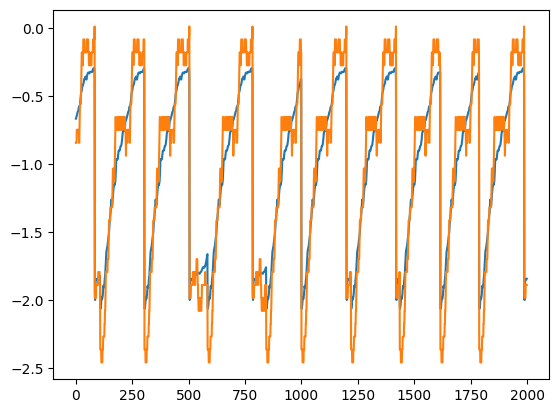

In [ ]:
plot_predictions(model3, X0_test, y0_test)

#Gráfico con los valores originales sin la normalización

79/79 [==============================] - 0s 2ms/step


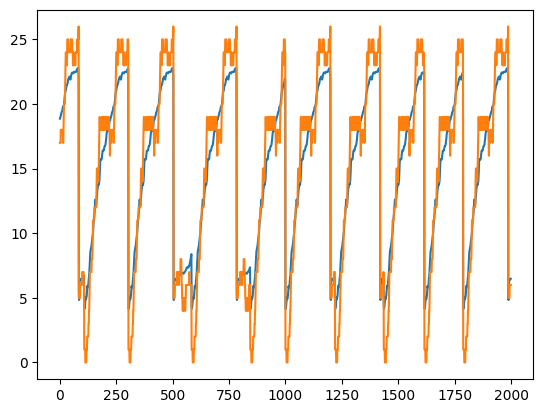

In [ ]:
y0tst = scaler.inverse_transform(y0_test)
y0p= scaler.inverse_transform(model3.predict(X0_test))
per1_p = y0p[:, 0]
per1_a = y0tst[:, 0]
df1 = pd.DataFrame(data={'Persona1 predicción': per1_p,
                          'Persona1 actual': per1_a,
                                                    })
plt.plot(df1['Persona1 predicción'][0:2000])
plt.plot(df1['Persona1 actual'][0:2000])




In [ ]:
df1

,Persona1 predicción,Persona1 actual
0,18.866785,17.0
1,18.912786,17.0
2,18.973385,17.0
3,19.035273,17.0
4,19.109392,18.0
...,...,...
2495,11.523730,14.0
2496,11.599099,14.0
2497,11.667077,14.0
2498,11.708803,14.0


# Producción de datos usando el modelo3 generando 4 trueques nuevos

In [ ]:
R=np.random.randint(1, 51, size=12)
R1=np.random.randint(1, 51, size=12)
n_m = tru_mut(R,R1)[1]
n_mm=n_m[:4, :]
N_mm=n_mm.copy()

In [ ]:
N_mm

array([[31,  6, 29, 26, 27, 38,  8, 39, 12, 47, 25, 31,  9, 25, 19, 42,
        46, 41, 27, 40, 47, 19, 47, 12],
       [31,  6, 29, 26, 26, 38,  9, 39, 12, 47, 25, 31,  8, 25, 19, 43,
        46, 41, 27, 40, 47, 19, 47, 12],
       [31,  6, 29, 26, 26, 38,  9, 39, 12, 47, 25, 31,  9, 25, 19, 43,
        46, 41, 27, 39, 47, 19, 47, 12],
       [32,  6, 29, 26, 26, 37,  9, 39, 12, 47, 25, 31,  9, 25, 19, 43,
        46, 41, 27, 39, 47, 19, 47, 12]])

In [ ]:
scaler1 = StandardScaler()
n_mmi = scaler1.fit_transform(n_mm)
n_mmi

array([[-0.57735027,  0.        ,  0.        ,  0.        ,  1.73205081,
         0.57735027, -1.73205081,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.57735027,  0.        ,  0.        ,
        -1.73205081,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.57735027,  0.        ,  0.        ,  0.        , -0.57735027,
         0.57735027,  0.57735027,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.73205081,  0.        ,  0.        ,
         0.57735027,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.57735027,  0.        ,  0.        ,  0.        , -0.57735027,
         0.57735027,  0.57735027,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.57735027,  0.        ,  0.        ,
         0.57735027,  0.        ,  0.        ,  0.        , -1.        ,
  

In [ ]:
XX=np.array([n_mmi])
tt=np.arange(0, 301, 1)
varJ = np.zeros(len(tt))
for step in range(300):
  K = np.array([XX[0, step:step+4, :]])
  H=model3.predict(K)
  HH=H[:, np.newaxis, :]
  XX = np.concatenate([XX, HH], axis=1)
  h = scaler1.inverse_transform(H)
  hh=np.round(h)
  hh = hh.astype(int)
  N_mm=np.concatenate((N_mm, hh), axis=0)
  varJ[step] = np.var(N_mm[step])
  print(varJ[step])
N_mm




1/1 [==============================] - 0s 21ms/step
170.02604166666666
1/1 [==============================] - 0s 20ms/step
171.359375
1/1 [==============================] - 0s 20ms/step
168.77604166666666
1/1 [==============================] - 0s 25ms/step
168.27604166666666
1/1 [==============================] - 0s 20ms/step
171.81770833333334
1/1 [==============================] - 0s 20ms/step
173.13888888888889
1/1 [==============================] - 0s 21ms/step
168.484375
1/1 [==============================] - 0s 20ms/step
169.24826388888889
1/1 [==============================] - 0s 27ms/step
169.24826388888889
1/1 [==============================] - 0s 21ms/step
169.24826388888889
1/1 [==============================] - 0s 20ms/step
169.24826388888889
1/1 [==============================] - 0s 21ms/step
169.24826388888889
1/1 [==============================] - 0s 28ms/step
169.24826388888889
1/1 [==============================] - 0s 25ms/step
169.24826388888889
1/1 [=================

array([[31,  6, 29, ..., 19, 47, 12],
       [31,  6, 29, ..., 19, 47, 12],
       [31,  6, 29, ..., 19, 47, 12],
       ...,
       [30,  5, 30, ..., 20, 46, 11],
       [30,  5, 30, ..., 20, 46, 11],
       [30,  5, 30, ..., 20, 46, 11]])

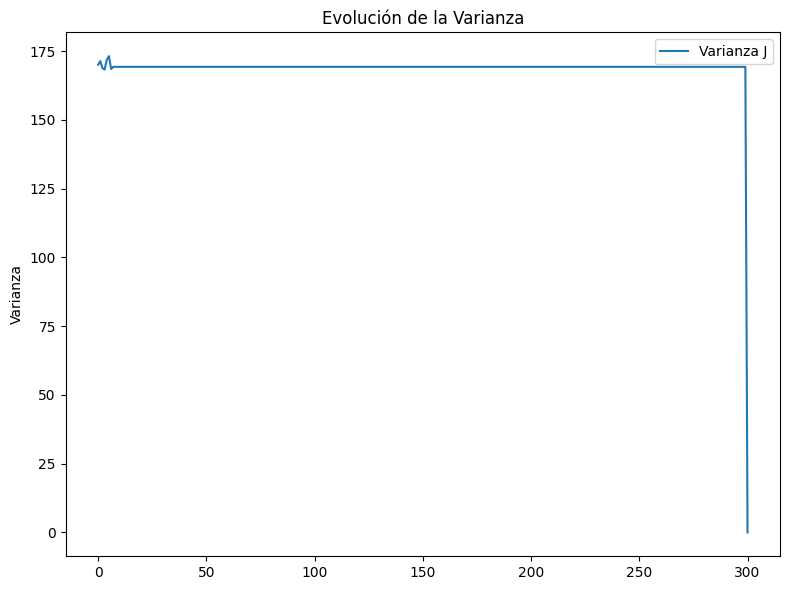

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
# Primer gráfico
axs.plot(tt, varJ, label='Varianza J')
axs.set_ylabel('Varianza')
axs.set_title('Evolución de la Varianza')
axs.legend()

plt.tight_layout()
plt.show()

In [ ]:
N_mm[0]

array([31,  6, 29, 26, 27, 38,  8, 39, 12, 47, 25, 31,  9, 25, 19, 42, 46,
       41, 27, 40, 47, 19, 47, 12])

Text(0, 0.5, 'Valor')

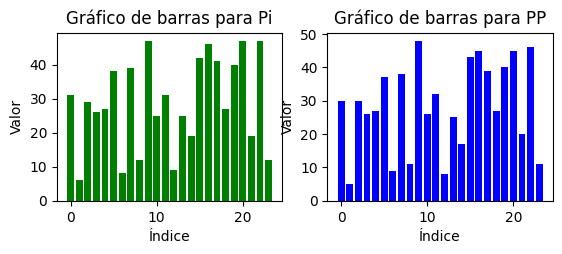

In [ ]:
indices = np.arange(len(N_mm[0]))

plt.subplot(2, 2, 1)
plt.bar(indices, N_mm[0], color='green')
plt.title('Gráfico de barras para Pi')
plt.xlabel('Índice')
plt.ylabel('Valor')

plt.subplot(2, 2, 2)
plt.bar(indices, N_mm[299], color='blue')
plt.title('Gráfico de barras para PP')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Generación de datos y gráfica de varianza empezando con 4 primeras filas de X0_test

In [ ]:
A=[]
Xx=X0_test[:1]
tt=np.arange(0, 301, 1)
varJJ = np.zeros(len(tt))
for step in range(300):
  K = np.array([Xx[0, step:step+4, :]])
  H=model3.predict(K)
  HH=H[:, np.newaxis, :]
  Xx = np.concatenate([Xx, HH], axis=1)
  h = scaler1.inverse_transform(H)
  hh=np.round(h)
  hh = hh.astype(int)
  A.append(hh)
  #A=np.concatenate((A, hh), axis=0)
  varJJ[step] = np.var(A[step])
  print(varJJ[step])
A

1/1 [==============================] - 0s 38ms/step
174.55555555555557
1/1 [==============================] - 0s 36ms/step
174.55555555555557
1/1 [==============================] - 0s 38ms/step
174.55555555555557
1/1 [==============================] - 0s 40ms/step
174.83159722222226
1/1 [==============================] - 0s 38ms/step
174.55555555555557
1/1 [==============================] - 0s 40ms/step
174.83159722222226
1/1 [==============================] - 0s 39ms/step
174.83159722222226
1/1 [==============================] - 0s 38ms/step
176.52083333333334
1/1 [==============================] - 0s 47ms/step
176.52083333333334
1/1 [==============================] - 0s 34ms/step
176.52083333333334
1/1 [==============================] - 0s 40ms/step
174.66493055555554
1/1 [==============================] - 0s 70ms/step
174.66493055555554
1/1 [==============================] - 0s 42ms/step
174.66493055555554
1/1 [==============================] - 0s 73ms/step
174.66493055555554
1/1 [=

[array([[31,  6, 29, 26, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 26, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 26, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 25, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 26, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 25, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 25, 26, 38,  8, 39, 11, 48, 25, 31,  9, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 25, 26, 38,  8, 39, 11, 48, 25, 31,  8, 25, 19, 43,
         47, 41, 26, 40, 47, 19, 46, 12]]),
 array([[31,  6, 29, 25, 26, 38,  8, 39, 11, 48, 25, 31,  8, 25,

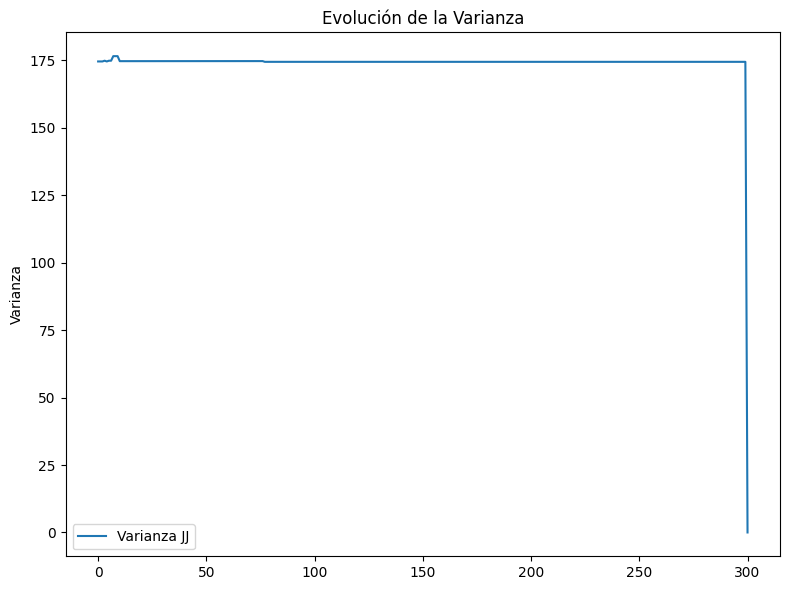

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
# Primer gráfico
axs.plot(tt, varJJ, label='Varianza JJ')
axs.set_ylabel('Varianza')
axs.set_title('Evolución de la Varianza')
axs.legend()

plt.tight_layout()
plt.show()